In [1]:
import pandas as pd
import numpy as np
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
raw_csv = pd.read_csv('Index2018.csv')
df = raw_csv.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index('date', inplace=True)
df = df.asfreq('b')
df = df.fillna(method='ffill')

In [3]:
df['market_value'] = df.spx
del df['spx']
# del df['dax']
del df['ftse']
del df['nikkei']
size = int(len(df)*0.8)
train, test = df.iloc[:size], df.iloc[size:]

### White Noise

In [4]:
wn = np.random.normal(loc = df.market_value.mean(), scale = df.market_value.std(), size = len(df))
df['wn'] = wn
df.describe()

,dax,market_value,wn
count,6277.000000,6277.000000,6277.000000
mean,6083.381061,1288.642547,1291.977402
std,2755.563853,487.868210,483.484177
min,1911.700000,438.920000,-489.046067
25%,4070.460000,992.715221,973.736521
50%,5774.260000,1233.761241,1293.643490
75%,7445.560000,1460.250000,1606.160049
max,13559.600000,2872.867839,3189.734606


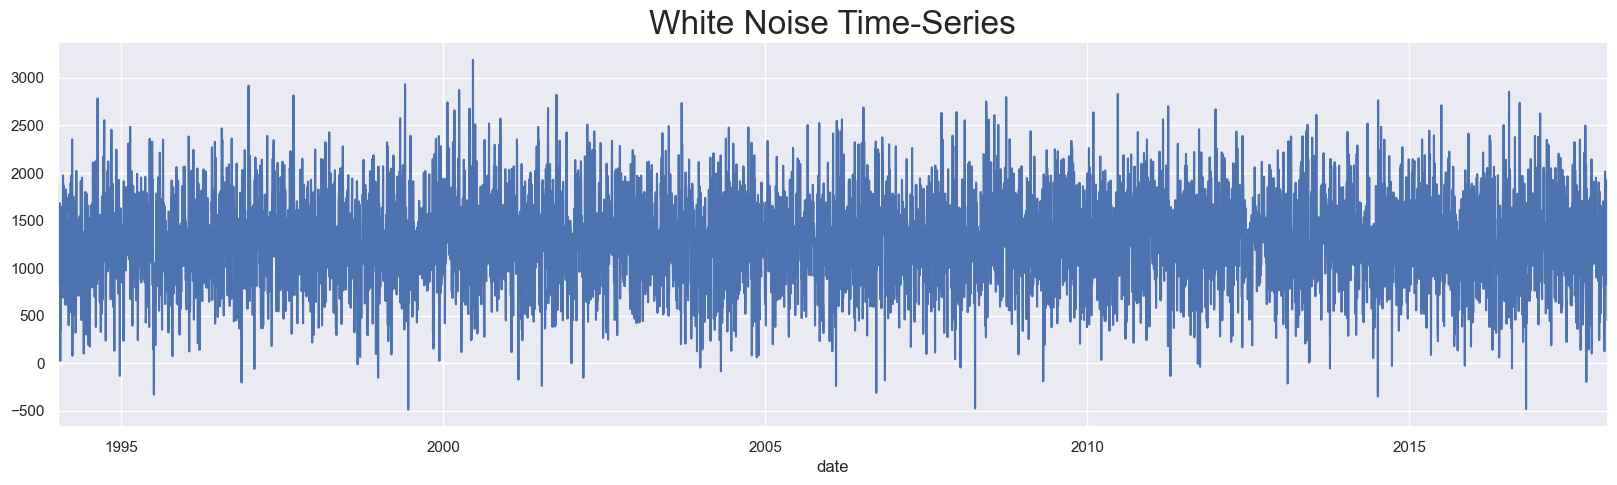

In [5]:
df.wn.plot(figsize = (20, 5))
plt.title('White Noise Time-Series', size=24)
plt.show()

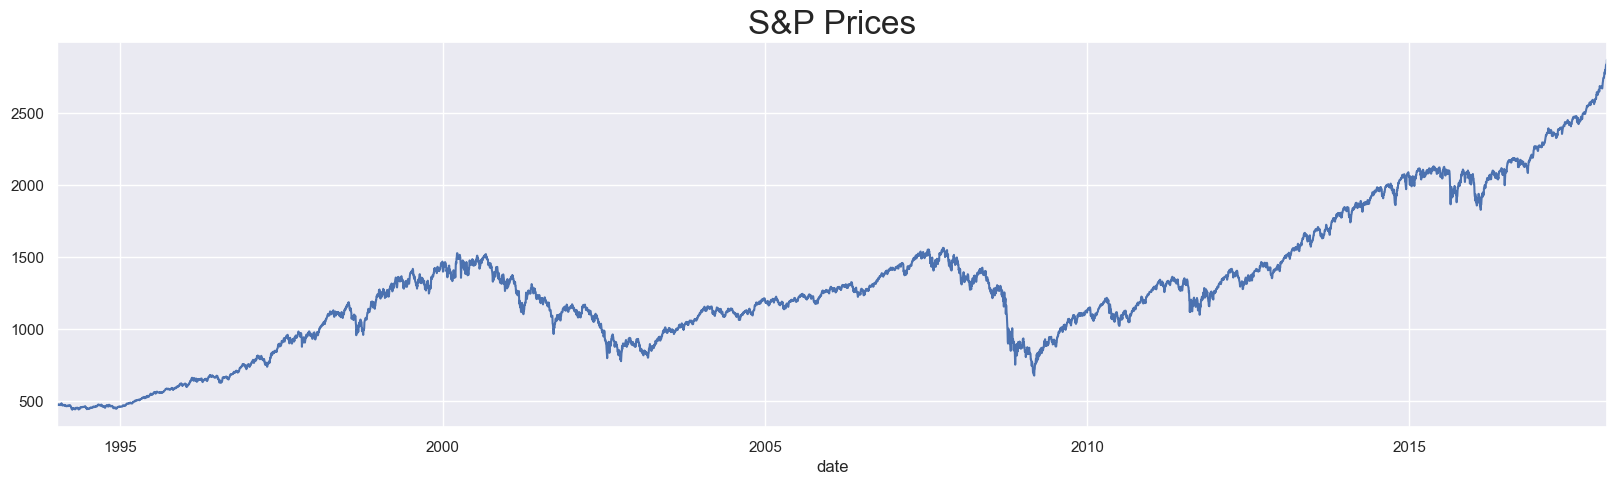

In [6]:
df.market_value.plot(figsize = (20, 5))
plt.title('S&P Prices', size=24)
plt.show()

### Random Walk

In [7]:
rw = pd.read_csv('RandWalk.csv')
rw.date = pd.to_datetime(rw.date, dayfirst = True)
rw.set_index('date', inplace=True)
rw = rw.asfreq('b')
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [8]:
df['rw'] = rw.price
df.tail()

,dax,market_value,wn,rw
date,,,,
2018-01-23,13559.60,2839.130362,831.113293,NaN
2018-01-24,13414.74,2837.544008,1923.073640,NaN
2018-01-25,13298.36,2839.253031,1700.864482,NaN
2018-01-26,13340.17,2872.867839,1123.453264,NaN
2018-01-29,13324.48,2853.528411,452.747839,NaN


In [9]:
df.dropna(inplace=True)
df.tail()

,dax,market_value,wn,rw
date,,,,
2013-04-01,7795.31,1562.173837,1496.053319,2263.675474
2013-04-02,7943.87,1570.252238,1422.718647,2225.000870
2013-04-03,7874.75,1553.686978,1427.971272,2190.787688
2013-04-04,7817.39,1559.979316,1552.542287,2195.240033
2013-04-05,7658.75,1553.278930,1403.349593,2152.992143


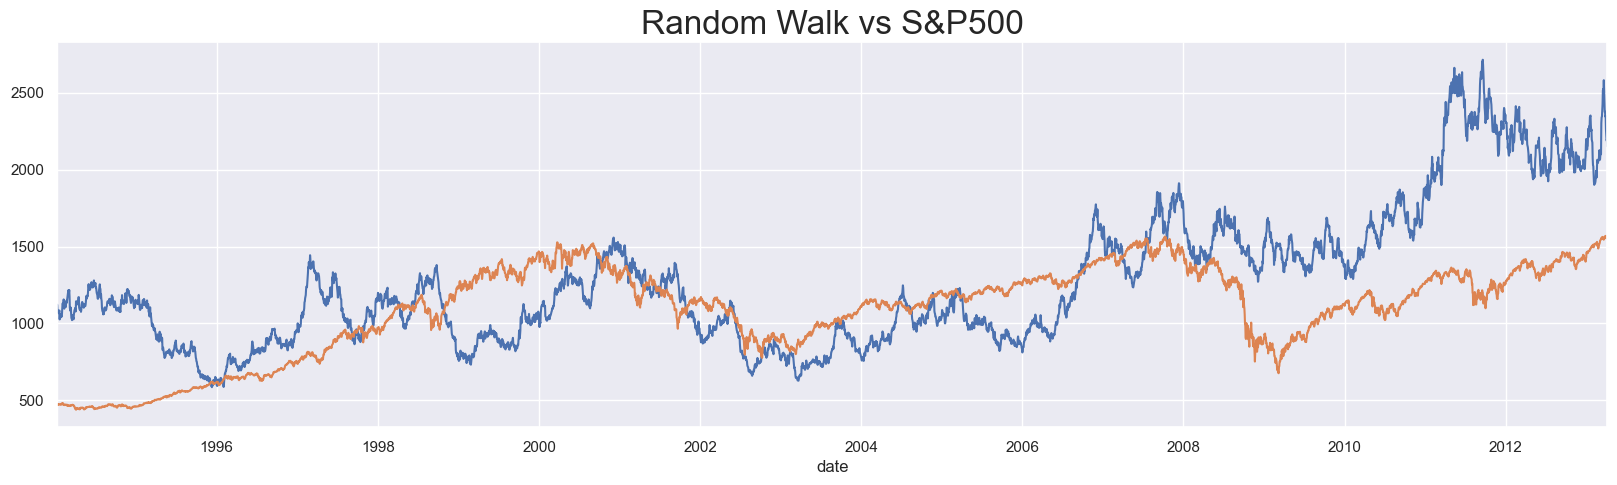

In [10]:
df.rw.plot(figsize = (20, 5))
df.market_value.plot()
plt.title('Random Walk vs S&P500', size=24)
plt.show()

### Stationarity

In [11]:
sts.adfuller(df.market_value)

(-1.7369847452352436,
 0.4121645696770623,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

In [12]:
sts.adfuller(df.wn)

(-70.64763993279468,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 75755.45238862679)

In [13]:
sts.adfuller(df.rw)

(-1.3286073927689719,
 0.6159849181617385,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

### Seasonality

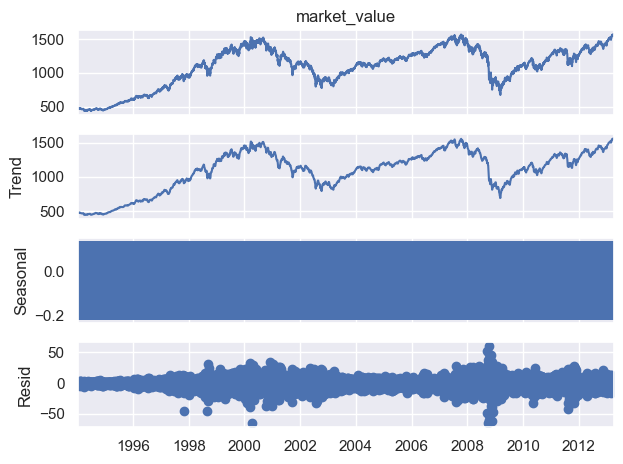

In [14]:
s_dec_add = seasonal_decompose(df.market_value, model = 'additive')
s_dec_add.plot()
plt.show()

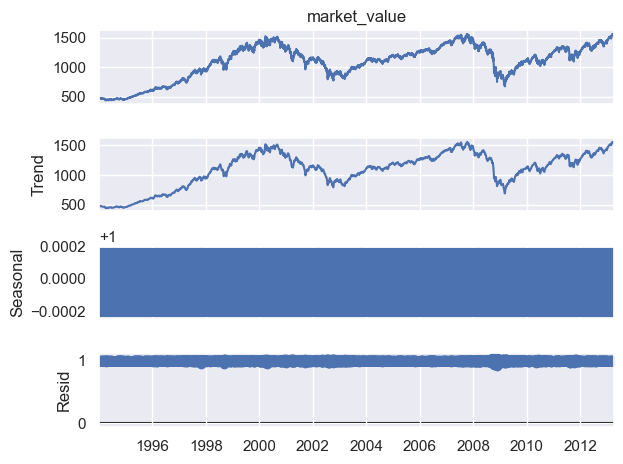

In [15]:
s_dec_mult = seasonal_decompose(df.market_value, model = 'multiplicative')
s_dec_mult.plot()
plt.show()

### ACF

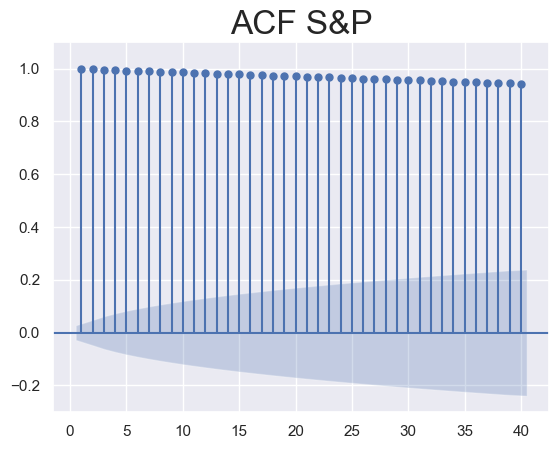

In [16]:
sgt.plot_acf(df.market_value, lags = 40, zero = False)
plt.title('ACF S&P', size = 24)
plt.ylim(-0.3, 1.1)
plt.show()

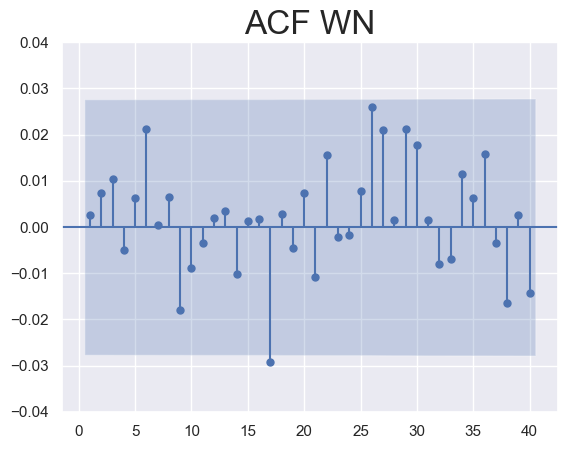

In [17]:
sgt.plot_acf(df.wn, lags = 40, zero = False)
plt.title('ACF WN', size = 24)
plt.ylim(-0.04, 0.04)
plt.show()

### PACF

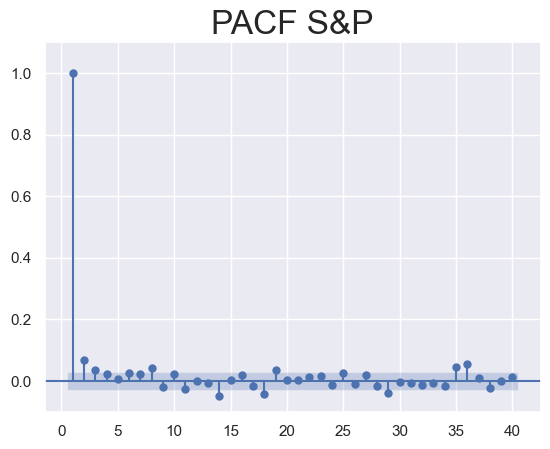

In [18]:
sgt.plot_pacf(df.market_value, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title('PACF S&P', size=24)
plt.ylim(-0.1, 1.1)
plt.show()

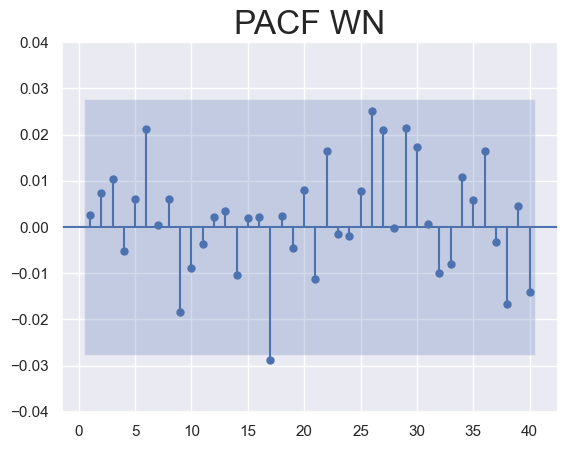

In [19]:
sgt.plot_pacf(df.wn, lags = 40, zero = False, method = ('ols'))
plt.title('PACF WN', size=24)
plt.ylim(-0.04, 0.04)
plt.show()

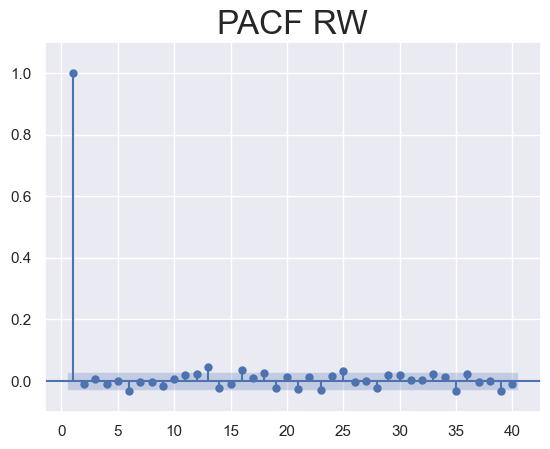

In [20]:
sgt.plot_pacf(df.rw, lags = 40, zero = False, method = ('ols'))
plt.title('PACF RW', size=24)
plt.ylim(-0.1, 1.1)
plt.show()

### The AR(1) Model

In [21]:
ar = ARIMA(df.market_value, order =(1, 0, 0))
results_ar = ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -20097.439
Date:                Fri, 25 Apr 2025   AIC                          40200.879
Time:                        20:55:57   BIC                          40220.443
Sample:                    01-07-1994   HQIC                         40207.734
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6133    165.184      6.608      0.000     767.858    1415.369
ar.L1          0.9992      0.001   1695.377      0.000       0.998       1.000
sigma2       175.2480      1.771     98.978      0.000     171.778     178.718
===================================================================================
Ljung-Box (L1) (Q):                  24.60   Jarque-Bera (JB):              7473.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Higher-Lag AR Models

In [22]:
ar_2 = ARIMA(df.market_value, order =(2, 0, 0))
results_ar2 = ar_2.fit()
results_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -20085.289
Date:                Fri, 25 Apr 2025   AIC                          40178.578
Time:                        20:55:58   BIC                          40204.664
Sample:                    01-07-1994   HQIC                         40187.719
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6076    223.343      4.888      0.000     653.863    1529.352
ar.L1          0.9300      0.009     99.031      0.000       0.912       0.948
ar.L2          0.0694      0.009      7.405      0.000       0.051       0.088
sigma2       174.3966      1.768     98.654      0.000     170.932     177.861
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              7475.27
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
ar_3 = ARIMA(df.market_value, order =(3, 0, 0))
results_ar3 = ar_3.fit()
results_ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -20083.003
Date:                Fri, 25 Apr 2025   AIC                          40176.005
Time:                        20:55:59   BIC                          40208.612
Sample:                    01-07-1994   HQIC                         40187.431
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6519    119.496      9.135      0.000     857.444    1325.860
ar.L1          0.9271      0.009     97.886      0.000       0.909       0.946
ar.L2          0.0376      0.012      3.227      0.001       0.015       0.060
ar.L3          0.0342      0.008      4.437      0.000       0.019       0.049
sigma2       174.1643      1.799     96.828      0.000     170.639     177.690
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7224.32
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
ar_4 = ARIMA(df.market_value, order =(4, 0, 0))
results_ar4 = ar_4.fit()
results_ar4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -20081.936
Date:                Fri, 25 Apr 2025   AIC                          40175.873
Time:                        20:55:59   BIC                          40215.001
Sample:                    01-07-1994   HQIC                         40189.584
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6519    121.400      8.992      0.000     853.713    1329.591
ar.L1          0.9264      0.009     97.776      0.000       0.908       0.945
ar.L2          0.0368      0.012      3.147      0.002       0.014       0.060
ar.L3          0.0148      0.012      1.272      0.203      -0.008       0.038
ar.L4          0.0208      0.009      2.249      0.025       0.003       0.039
sigma2       174.1229      1.800     96.734      0.000     170.595     177.651
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7229.16
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### LLR Test
General Rule: We prefer models with a High Log Likelihood but lower Information Criteria. We can use the Log-Likelihood Ratio test or (LLR) test.

In [25]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

### Comparing Higher-Lag AR Models

In [26]:
LLR_test(ar, ar_2)

0.0

In [27]:
LLR_test(ar_2, ar_3)

0.032

In [28]:
LLR_test(ar_3, ar_4)

0.144

In [29]:
ar_5 = ARIMA(df.market_value, order =(5, 0, 0))
results_ar5 = ar_5.fit()
print(results_ar5.summary())
print("\nLLR test p-value = " + str(LLR_test(ar_4, ar_5)))

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -20081.852
Date:                Fri, 25 Apr 2025   AIC                          40177.704
Time:                        20:56:05   BIC                          40223.353
Sample:                    01-07-1994   HQIC                         40193.700
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6519    122.004      8.948      0.000     852.529    1330.775
ar.L1          0.9263      0.009     97.701      0.000       0.908       0.945
ar.L2          0.0367      0.012      3.138      0.0

### Using Returns

In [30]:
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

In [31]:
sts.adfuller(df.returns)

(-17.03445719098122,
 8.280537020316351e-30,
 17,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 16035.926219345134)

### ACF and PACF for Returns

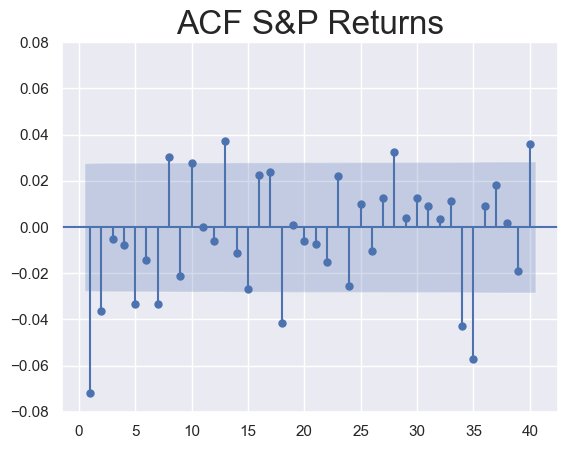

In [32]:
sgt.plot_acf(df.returns, lags = 40, zero = False)
plt.title('ACF S&P Returns', size = 24)
plt.ylim(-0.08, 0.08)
plt.show()

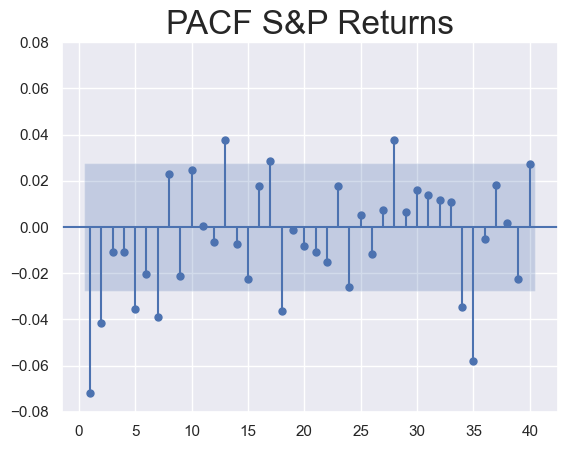

In [33]:
sgt.plot_pacf(df.returns, lags = 40, zero = False, method =('ols'))
plt.title('PACF S&P Returns', size = 24)
plt.ylim(-0.08, 0.08)
plt.show()

### AR(1) for Returns

In [34]:
ret_ar1 = ARIMA(df.returns, order =(1, 0, 0))
ret_results_ar1 = ret_ar1.fit()
ret_results_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -8067.541
Date:                Fri, 25 Apr 2025   AIC                          16141.081
Time:                        20:56:08   BIC                          16160.645
Sample:                    01-10-1994   HQIC                         16147.937
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.016      1.915      0.055      -0.001       0.063
ar.L1         -0.0719      0.008     -8.514      0.000      -0.088      -0.055
sigma2         1.4568      0.013    114.005      0.000       1.432       1.482
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             14951.82
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Higher-Lag AR Models for Returns

In [35]:
ret_ar2 = ARIMA(df.returns, order =(2, 0, 0))
ret_results_ar2 = ret_ar2.fit()
ret_results_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -8063.177
Date:                Fri, 25 Apr 2025   AIC                          16134.354
Time:                        20:56:08   BIC                          16160.439
Sample:                    01-10-1994   HQIC                         16143.494
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.016      1.963      0.050    5.43e-05       0.062
ar.L1         -0.0749      0.009     -8.788      0.000      -0.092      -0.058
ar.L2         -0.0417      0.007     -6.035      0.000      -0.055      -0.028
sigma2         1.4543      0.013    108.088      0.000       1.428       1.481
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13914.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
LLR_test(ret_ar1, ret_ar2)

0.003

In [37]:
ret_ar3 = ARIMA(df.returns, order =(3, 0, 0))
ret_results_ar3 = ret_ar3.fit()
ret_results_ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -8062.879
Date:                Fri, 25 Apr 2025   AIC                          16135.758
Time:                        20:56:10   BIC                          16168.364
Sample:                    01-10-1994   HQIC                         16147.184
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.016      1.971      0.049       0.000       0.062
ar.L1         -0.0753      0.009     -8.850      0.000      -0.092      -0.059
ar.L2         -0.0425      0.007     -6.159      0.000      -0.056      -0.029
ar.L3         -0.0109      0.008     -1.318      0.188      -0.027       0.005
sigma2         1.4541      0.013    108.106      0.000       1.428       1.481
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13902.15
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
LLR_test(ret_ar2, ret_ar3)

0.44

### Normalizing Values

In [39]:
benchmark = df.market_value.iloc[0]
df['norm'] = df.market_value.div(benchmark)
sts.adfuller(df.norm)

(-1.7396871077363418,
 0.4107891338211873,
 18,
 5001,
 {'1%': -3.431658270286891,
  '5%': -2.8621181140235223,
  '10%': -2.5670777307913744},
 -21580.688735694894)

### Normalizing Returns
Normalizing does not affect stationarity

In [40]:
bench_ret = df.returns.iloc[0]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)
sts.adfuller(df.norm_ret)

(-17.03445719098116,
 8.28053702031718e-30,
 17,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 60636.5822032878)

### Normalized Returns
Using normalized values has no impact on model selection

In [41]:
norm_ret_ar1 = ARIMA(df.norm_ret, order =(1, 0, 0))
norm_ret_results_ar1 = norm_ret_ar1.fit()
norm_ret_results_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -30515.434
Date:                Fri, 25 Apr 2025   AIC                          61036.869
Time:                        20:56:12   BIC                          61056.432
Sample:                    01-10-1994   HQIC                         61043.724
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7256      1.423      1.915      0.055      -0.063       5.515
ar.L1         -0.0719      0.008     -8.514      0.000      -0.088      -0.055
sigma2      1.116e+04     97.856    114.000      0.000     1.1e+04    1.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             14951.79
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
norm_ret_ar2 = ARIMA(df.norm_ret, order =(2, 0, 0))
norm_ret_results_ar2 = norm_ret_ar2.fit()
norm_ret_results_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -30511.071
Date:                Fri, 25 Apr 2025   AIC                          61030.142
Time:                        20:56:12   BIC                          61056.227
Sample:                    01-10-1994   HQIC                         61039.282
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7256      1.388      1.964      0.050       0.005       5.446
ar.L1         -0.0749      0.009     -8.787      0.000      -0.092      -0.058
ar.L2         -0.0417      0.007     -6.033      0.000      -0.055      -0.028
sigma2      1.114e+04    103.073    108.063      0.000    1.09e+04    1.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13914.64
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Analysing the Residuals

In [43]:
df['res_price'] = results_ar3.resid

In [44]:
df.res_price.mean()

0.23864631954230364

In [45]:
df.res_price.var()

174.07577844822535

In [46]:
sts.adfuller(df.res_price)

(-16.385977328247744,
 2.7228559994389745e-29,
 17,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39895.8038437075)

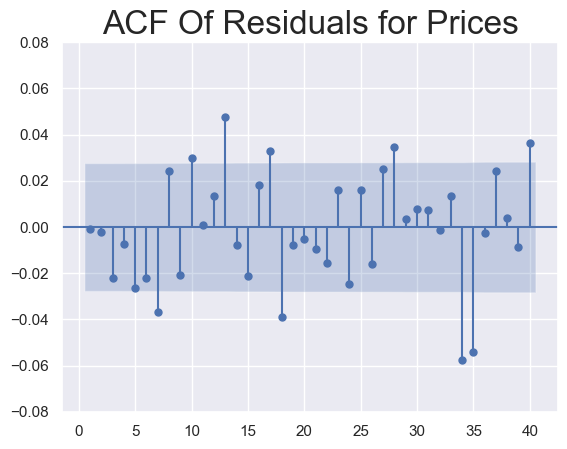

In [47]:
sgt.plot_acf(df.res_price, lags = 40, zero = False)
plt.title('ACF Of Residuals for Prices', size = 24)
plt.ylim(-0.08, 0.08)
plt.show()

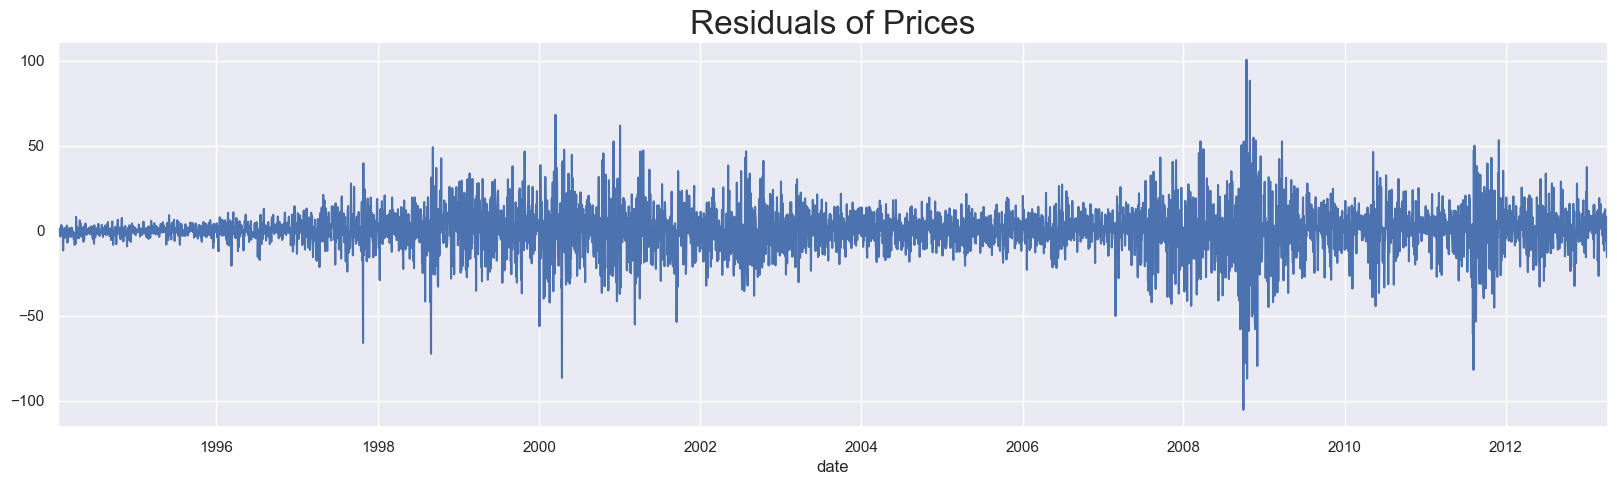

In [48]:
df.res_price[1:].plot(figsize=(20,5))
plt.title('Residuals of Prices', size=24)
plt.show()

In [49]:
df['res_ret'] = ret_results_ar2.resid

In [50]:
df.res_ret.mean()

2.032339021405912e-05

In [51]:
df.res_ret.std()

1.2060750888957383

In [52]:
sts.adfuller(df.res_ret)

(-16.961420305258383,
 9.302280007299928e-30,
 17,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 16035.800317293033)

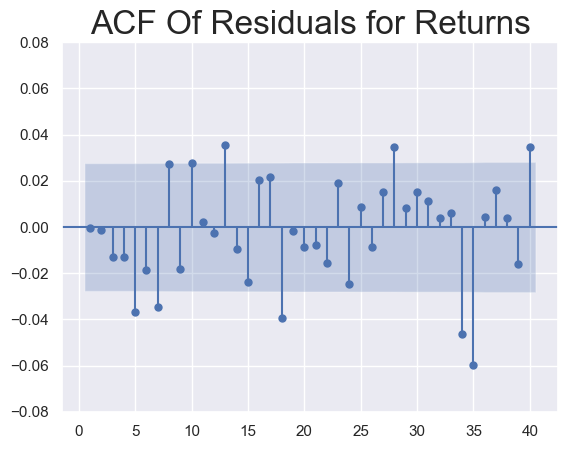

In [53]:
sgt.plot_acf(df.res_ret, lags = 40, zero = False)
plt.title('ACF Of Residuals for Returns', size = 24)
plt.ylim(-0.08, 0.08)
plt.show()

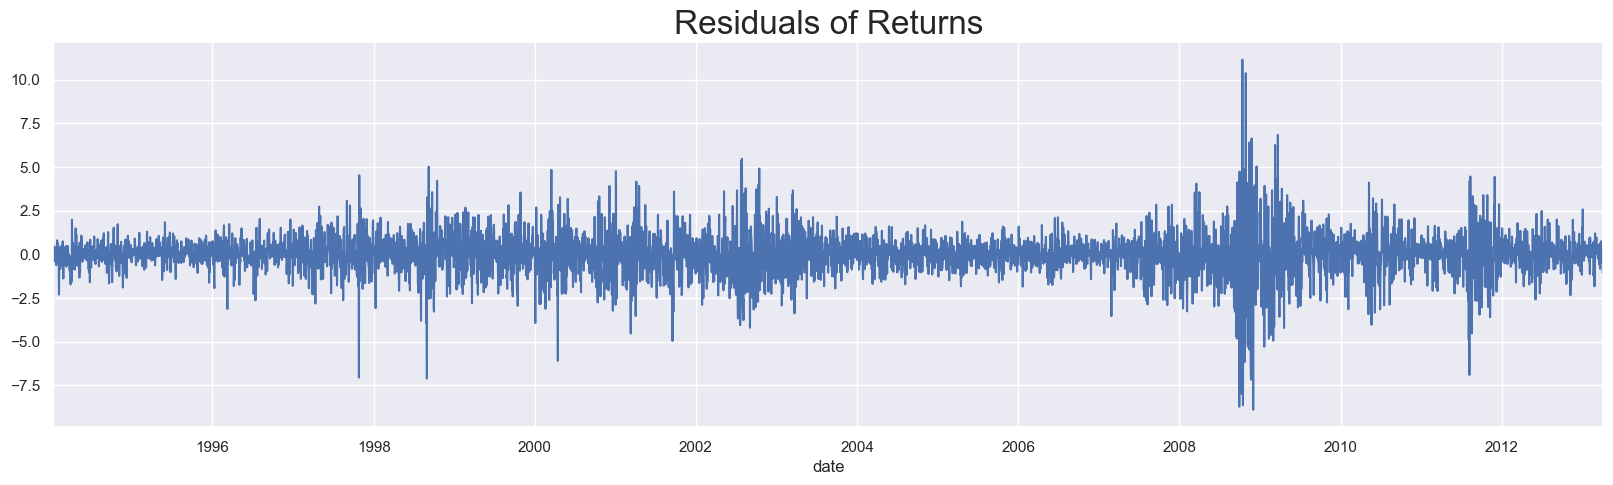

In [54]:
df.res_ret[1:].plot(figsize=(20,5))
plt.title('Residuals of Returns', size=24)
plt.show()

### MA(1) for Returns

In [55]:
ret_ma1 = ARIMA(df.returns, order =(0, 0, 1))
ret_results_ma1 = ret_ma1.fit()
ret_results_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -8066.419
Date:                Fri, 25 Apr 2025   AIC                          16138.839
Time:                        20:56:14   BIC                          16158.402
Sample:                    01-10-1994   HQIC                         16145.694
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.016      1.924      0.054      -0.001       0.063
ma.L1         -0.0781      0.008     -9.247      0.000      -0.095      -0.062
sigma2         1.4562      0.013    112.935      0.000       1.431       1.481
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             14759.58
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
ret_ma2 = ARIMA(df.returns, order =(0, 0, 2))
ret_results_ma2 = ret_ma2.fit()
print(ret_results_ma2.summary())
print("\nLLR test p-value = " + str(LLR_test(ret_ma1, ret_ma2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -8062.759
Date:                Fri, 25 Apr 2025   AIC                          16133.518
Time:                        20:56:15   BIC                          16159.603
Sample:                    01-10-1994   HQIC                         16142.659
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.016      1.972      0.049       0.000       0.062
ma.L1         -0.0759      0.008     -8.961      0.000      -0.093      -0.059
ma.L2         -0.0389      0.007     -5.644      0.0

In [57]:
ret_ma3 = ARIMA(df.returns, order =(0, 0, 3))
ret_results_ma3 = ret_ma3.fit()
print(ret_results_ma3.summary())
print("\nLLR test p-value = " + str(LLR_test(ret_ma2, ret_ma3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -8062.500
Date:                Fri, 25 Apr 2025   AIC                          16134.999
Time:                        20:56:17   BIC                          16167.605
Sample:                    01-10-1994   HQIC                         16146.425
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.016      1.980      0.048       0.000       0.062
ma.L1         -0.0759      0.008     -8.926      0.000      -0.093      -0.059
ma.L2         -0.0389      0.007     -5.633      0.0

In [58]:
ret_ma5 = ARIMA(df.returns, order =(0, 0, 5))
ret_results_ma5 = ret_ma5.fit()
print(ret_results_ma5.summary())
print("\nLLR test p-value = " + str(LLR_test(ret_ma2, ret_ma5, DF=3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -8058.465
Date:                Fri, 25 Apr 2025   AIC                          16130.930
Time:                        20:56:19   BIC                          16176.578
Sample:                    01-10-1994   HQIC                         16146.926
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.015      2.054      0.040       0.001       0.061
ma.L1         -0.0774      0.009     -9.020      0.000      -0.094      -0.061
ma.L2         -0.0404      0.007     -5.836      0.0

In [59]:
ret_ma7 = ARIMA(df.returns, order =(0, 0, 7))
ret_results_ma7 = ret_ma7.fit()
print(ret_results_ma7.summary())
print("\nLLR test p-value = " + str(LLR_test(ret_ma2, ret_ma7, DF=5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -8055.652
Date:                Fri, 25 Apr 2025   AIC                          16129.304
Time:                        20:56:23   BIC                          16187.995
Sample:                    01-10-1994   HQIC                         16149.870
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.015      2.114      0.034       0.002       0.060
ma.L1         -0.0754      0.009     -8.776      0.000      -0.092      -0.059
ma.L2         -0.0394      0.007     -5.647      0.0

### Residuals for Returns

In [60]:
df['res_ret_ma7'] = ret_results_ma7.resid[1:]
print("The mean of the residual is " + str(round(df.res_ret_ma7.mean(),3)) + "\nThe variance of the residual is " + str(round(df.res_ret_ma7.var(),3)))

The mean of the residual is -0.0
The variance of the residual is 1.45


In [61]:
round(df.res_ret_ma7.std(), 3)

1.204

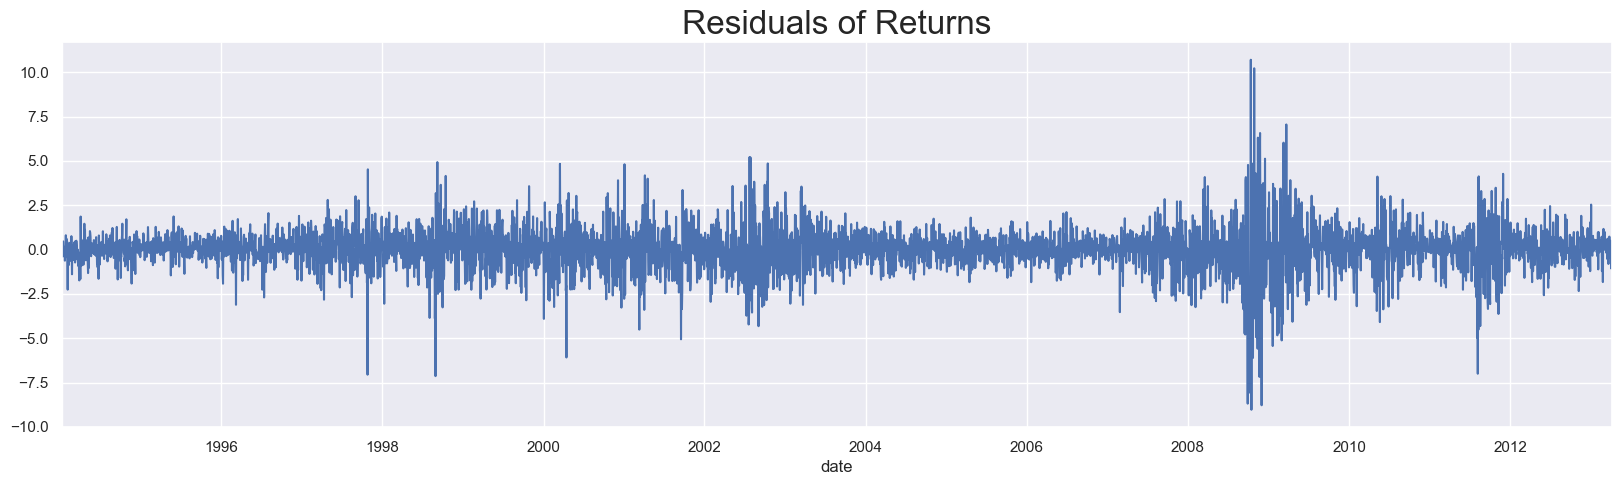

In [62]:
df.res_ret_ma7.plot(figsize =(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [63]:
sts.adfuller(df.res_ret_ma7[2:])

(-70.87873295390716,
 0.0,
 0,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 16028.506993463483)

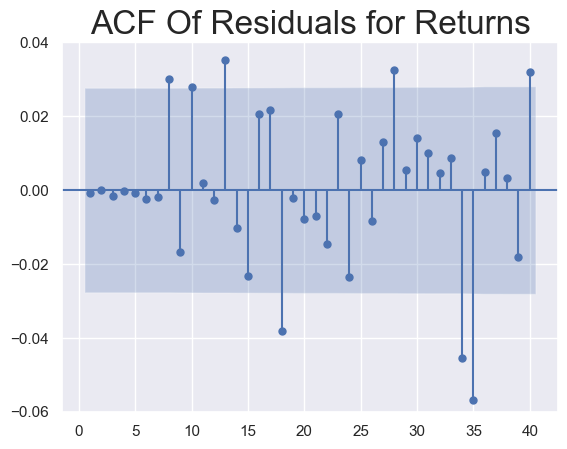

In [64]:
sgt.plot_acf(df.res_ret_ma7[2:], lags = 40, zero = False)
plt.title('ACF Of Residuals for Returns', size = 24)
plt.ylim(-0.06, 0.04)
plt.show()

#### ARMA(1,1)
ARMA does not have ACF or PACF functions do determine optimal number of lags.

ARMA Models perform well with stationary data

In [65]:
ret_ar1ma1 = ARIMA(df.returns, order =(1, 0, 1))
ret_results_ar1ma1 = ret_ar1ma1.fit()
ret_results_ar1ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8060.603
Date:                Fri, 25 Apr 2025   AIC                          16129.205
Time:                        20:56:27   BIC                          16155.290
Sample:                    01-10-1994   HQIC                         16138.346
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.015      2.049      0.040       0.001       0.061
ar.L1          0.6108      0.053     11.457      0.000       0.506       0.715
ma.L1         -0.6815      0.048    -14.152      0.000      -0.776      -0.587
sigma2         1.4528      0.013    108.660      0.000       1.427       1.479
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):             13590.07
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
print("\nARMA vs AR", LLR_test(ret_ar1, ret_ar1ma1))
print("\nARMA vs MA", LLR_test(ret_ma1, ret_ar1ma1))


ARMA vs AR 0.0

ARMA vs MA 0.001


### Higher-Lag ARMA Models

In [67]:
ret_ar2ma2 = ARIMA(df.returns, order =(2, 0, 2))
ret_results_ar2ma2 = ret_ar2ma2.fit()
print(ret_results_ar2ma2.summary())
print("\nLLR test p-value = " + str(LLR_test(ret_ar1ma1, ret_ar2ma2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -8060.480
Date:                Fri, 25 Apr 2025   AIC                          16132.960
Time:                        20:56:33   BIC                          16172.088
Sample:                    01-10-1994   HQIC                         16146.671
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.015      2.046      0.041       0.001       0.061
ar.L1          0.1231      0.848      0.145      0.885      -1.539       1.785
ar.L2          0.3320      0.513      0.647      0.5

In [68]:
ret_ar2ma1 = ARIMA(df.returns, order =(2, 0, 1))
ret_results_ar2ma1 = ret_ar2ma1.fit()
print(ret_results_ar2ma1.summary())
print("\nLLR test p-value = " + str(LLR_test(ret_ar1ma1, ret_ar2ma1)))
print("\nARMA(1,1):  \t LL = ",ret_results_ar1ma1.llf,"\t AIC = ",ret_results_ar1ma1.aic)
print("\nARMA(2,1):  \t LL = ",ret_results_ar2ma1.llf,"\t AIC = ",ret_results_ar2ma1.aic)

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -8060.158
Date:                Fri, 25 Apr 2025   AIC                          16130.315
Time:                        20:56:38   BIC                          16162.921
Sample:                    01-10-1994   HQIC                         16141.741
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.015      2.036      0.042       0.001       0.061
ar.L1          0.6751      0.062     10.822      0.000       0.553       0.797
ar.L2          0.0181      0.011      1.667      0.0

In [69]:
ret_ar1ma2 = ARIMA(df.returns, order =(2, 0, 1))
ret_results_ar1ma2 = ret_ar1ma2.fit()
print(ret_results_ar1ma2.summary())
print("\nLLR test p-value = " + str(LLR_test(ret_ar1ma1, ret_ar1ma2)))
print("\nARMA(1,1):  \t LL = ",ret_results_ar1ma1.llf,"\t AIC = ",ret_results_ar1ma1.aic)
print("\nARMA(1,2):  \t LL = ",ret_results_ar1ma2.llf,"\t AIC = ",ret_results_ar1ma2.aic)

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -8060.158
Date:                Fri, 25 Apr 2025   AIC                          16130.315
Time:                        20:56:43   BIC                          16162.921
Sample:                    01-10-1994   HQIC                         16141.741
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.015      2.036      0.042       0.001       0.061
ar.L1          0.6751      0.062     10.822      0.000       0.553       0.797
ar.L2          0.0181      0.011      1.667      0.0

In [70]:
df['res_ret_ar1ma1'] = ret_results_ar1ma1.resid[1:]
print("The mean of the residual is " + str(round(df.res_ret_ar1ma1.mean(),3)) + "\nThe variance of the residual is " + str(round(df.res_ret_ar1ma1.var(),3)))

The mean of the residual is -0.0
The variance of the residual is 1.453


In [71]:
round(df.res_ret_ar1ma1.std(), 3)

1.205

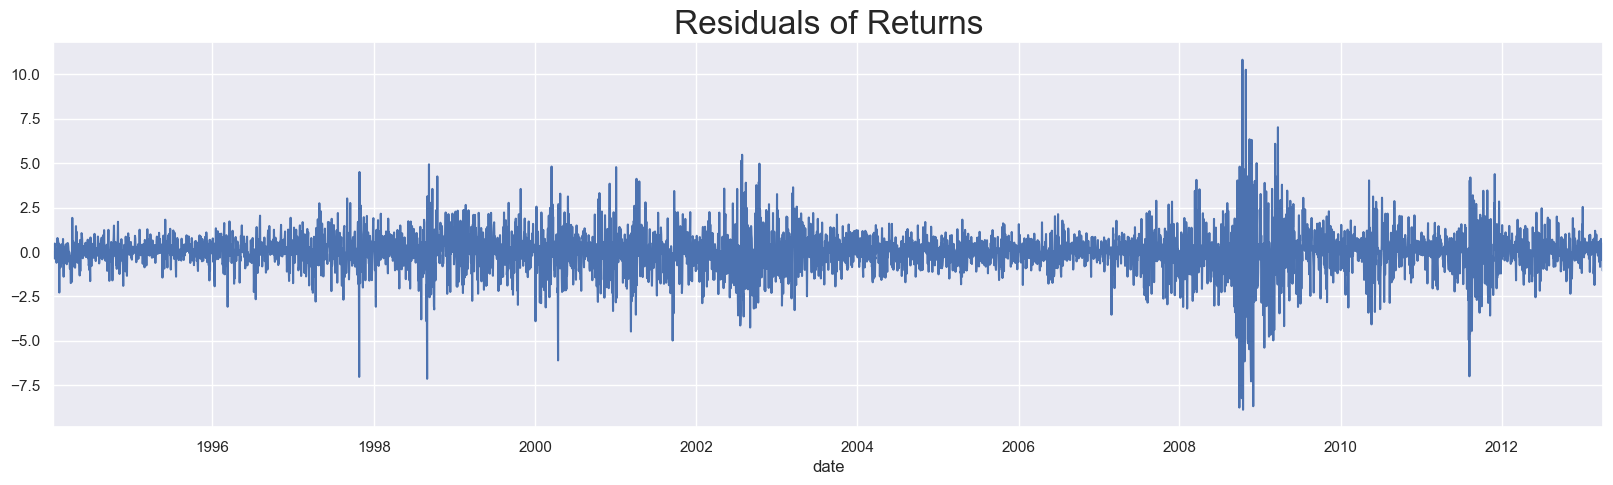

In [72]:
df.res_ret_ar1ma1.plot(figsize =(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

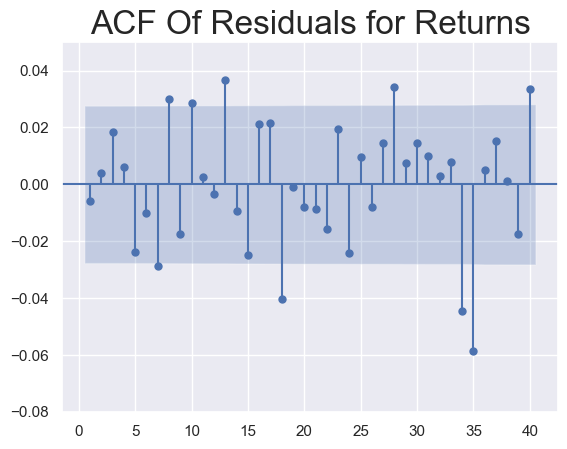

In [73]:
sgt.plot_acf(df.res_ret_ar1ma1[2:], lags = 40, zero = False)
plt.title('ACF Of Residuals for Returns', size = 24)
plt.ylim(-0.08, 0.05)
plt.show()

### ARIMA(1,1,1)
Usually we dont use ARIMA models for stationary data

In [74]:
ar1i1ma1 = ARIMA(df.market_value, order=(1,1,1))
results_ar1i1ma1 = ar1i1ma1.fit()
results_ar1i1ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20068.752
Date:                Fri, 25 Apr 2025   AIC                          40143.505
Time:                        20:56:47   BIC                          40163.068
Sample:                    01-10-1994   HQIC                         40150.360
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6011      0.063      9.532      0.000       0.478       0.725
ma.L1         -0.6694      0.057    -11.722      0.000      -0.781      -0.557
sigma2       174.0299      1.765     98.614      0.000     170.571     177.489
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              7328.28
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residuals of the ARIMA(1,1,1)

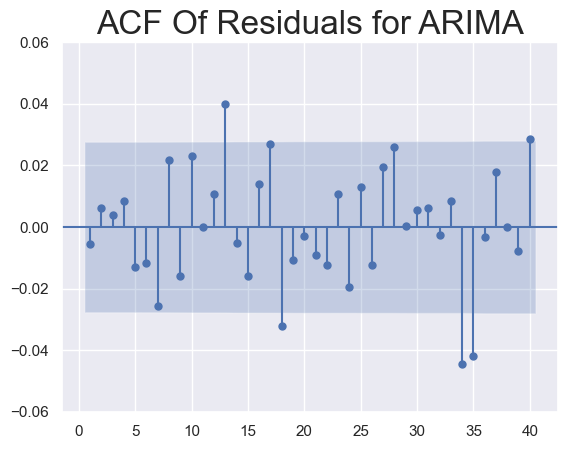

In [75]:
df["res_ar1i1ma1"] = results_ar1i1ma1.resid
sgt.plot_acf(df.res_ar1i1ma1, lags = 40, zero = False)
plt.title('ACF Of Residuals for ARIMA', size = 24)
plt.ylim(-0.06, 0.06)
plt.show()

In [76]:
ar13i1ma1 = ARIMA(df.market_value, order=(13,1,1))
results_ar13i1ma1 = ar13i1ma1.fit()

In [77]:
print("\nARIMA(1,1,1):  \t LL = ",results_ar1i1ma1.llf,"\t AIC = ",results_ar1i1ma1.aic)
print("\nARIMA(13,1,1):  \t LL = ",results_ar13i1ma1.llf,"\t AIC = ",results_ar13i1ma1.aic)
print("\nLLR test p-value = " + str(LLR_test(ar1i1ma1, ar13i1ma1)))


ARIMA(1,1,1):  	 LL =  -20068.752495442634 	 AIC =  40143.50499088527

ARIMA(13,1,1):  	 LL =  -20052.885927653202 	 AIC =  40135.771855306404

LLR test p-value = 0.0


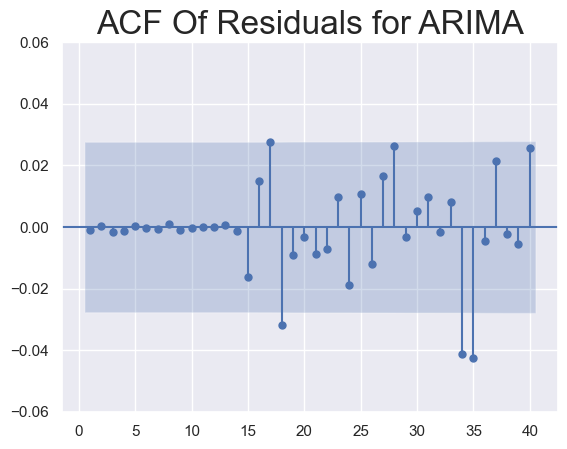

In [78]:
df["res_ar13i1ma1"] = results_ar13i1ma1.resid
sgt.plot_acf(df.res_ar13i1ma1, lags = 40, zero = False)
plt.title('ACF Of Residuals for ARIMA', size = 24)
plt.ylim(-0.06, 0.06)
plt.show()

### ARMAX / ARIMAX

In [79]:
ar1i1ma1_Xdax = ARIMA(df.market_value, exog = df.dax,order=(1,1,1))
results_ar1i1ma1_Xdax = ar1i1ma1_Xdax.fit()
results_ar1i1ma1_Xdax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -18901.672
Date:                Fri, 25 Apr 2025   AIC                          37811.344
Time:                        20:57:07   BIC                          37837.428
Sample:                    01-10-1994   HQIC                         37820.484
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dax            0.1105      0.001    100.399      0.000       0.108       0.113
ar.L1          0.1153      0.026      4.407      0.000       0.064       0.167
ma.L1         -0.4277      0.023    -18.344      0.000      -0.473      -0.382
sigma2       109.3052      1.179     92.747      0.000     106.995     111.615
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              5189.85
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
# create a 1‐period lag of DAX
df['dax_lag1'] = df['dax'].shift(1)

# now fit ARIMAX(1,1,1) using the lagged DAX
model = ARIMA(df['market_value'].iloc[1:], exog=df['dax_lag1'].iloc[1:], order=(1,1,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5019
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20058.595
Date:                Fri, 25 Apr 2025   AIC                          40125.190
Time:                        21:17:19   BIC                          40151.273
Sample:                    01-11-1994   HQIC                         40134.330
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dax_lag1       0.0118      0.002      5.429      0.000       0.008       0.016
ar.L1          0.4903      0.051      9.616      0.000       0.390       0.590
ma.L1         -0.5984      0.045    -13.202      0.0

### SARIMAX

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [85]:
sarimax = SARIMAX(df['market_value'].iloc[1:], exog=df['dax_lag1'].iloc[1:], order=(1,0,1), seasonal_order = (2,0,1,5))
results_sarimax = sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 5019
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -20073.994
Date:                           Fri, 25 Apr 2025   AIC                          40161.987
Time:                                   23:03:39   BIC                          40207.634
Sample:                               01-11-1994   HQIC                         40177.983
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dax_lag1       0.0090      0.002      4.577      0.000       0.005       0.013
ar.L1          0.9998      0.000   2383.360      0.000       0.999       1.001
ma.L1         -0.1070      0.011     -9.907      0.000      -0.128      -0.086
ar.S.L5        0.9757      0.005    178.047      0.000       0.965       0.986
ar.S.L10       0.0240      0.004      6.002      0.000       0.016       0.032
ma.S.L5       -0.9992      0.005   -191.320      0.000      -1.009      -0.989
sigma2       173.9854      1.834     94.857      0.000     170.391     177.580
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              7573.05
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Creating Square Returns

In [86]:
df['sq_returns'] = df.returns.mul(df.returns)

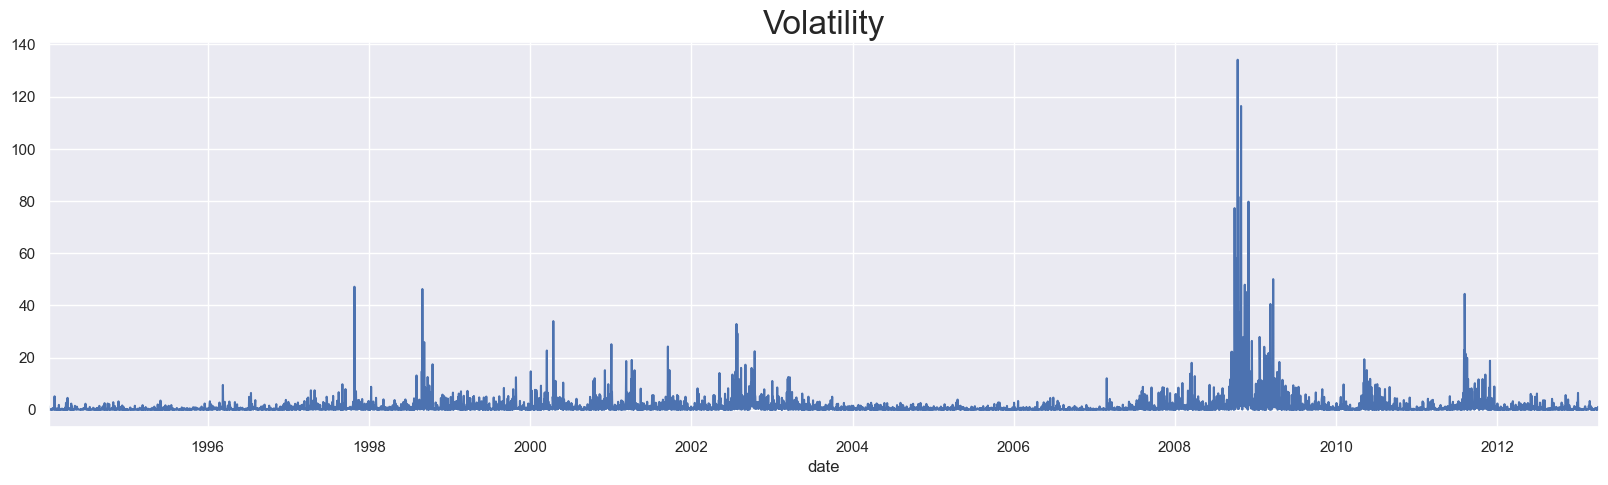

In [87]:
df.sq_returns.plot(figsize=(20,5))
plt.title('Volatility', size=24)
plt.show()

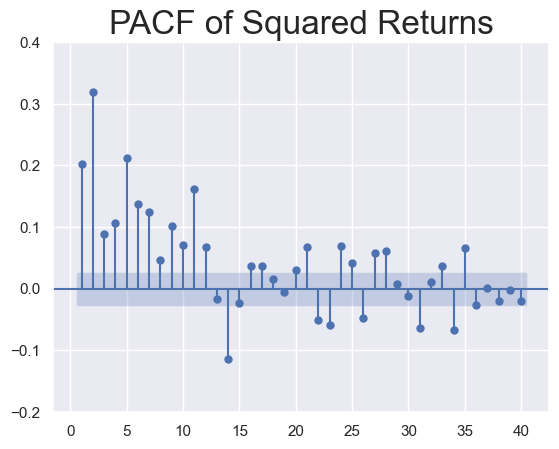

In [92]:
sgt.plot_pacf(df.sq_returns, lags = 40, zero = False, method=('ols'))
plt.title('PACF of Squared Returns', size = 24)
plt.ylim(-0.2, 0.4)
plt.show()

### ARCH MODEL

In [93]:
from arch import arch_model

In [94]:
arch1 = arch_model(df.returns)
results_arch1 = arch1.fit()
results_arch1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 210701343810718.44
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2765919683.1560593
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7052.396799215732
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7315.689990512834
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7048.303899059539
Iteration:      6,   Func. Count:     41,   Neg. LLF: 7005.861947476147
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7080.237525911539
Iteration:      8,   Func. Count:     53,   Neg. LLF: 7005.779776532088
Iteration:      9,   Func. Count:     59,   Neg. LLF: 7005.70834944984
Iteration:     10,   Func. Count:     65,   Neg. LLF: 7001.802278451896
Iteration:     11,   Func. Count:     70,   Neg. LLF: 7001.802244597651
Iteration:     12,   Func. Count:     74,   Neg. LLF: 7001.802244594717
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7001.802244597651
            Iterations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7001.80
Distribution:                  Normal   AIC:                           14011.6
Method:            Maximum Likelihood   BIC:                           14037.7
                                        No. Observations:                 5020
Date:                Fri, Apr 25 2025   Df Residuals:                     5019
Time:                        23:25:38   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0608  1.178e-02      5.160  2.475e-07 [3.769e-02,8.387e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.391e-03      3.222  1.275e-03 [4.278e-03,1.757e-02]
alpha[1]       0.0777  1.008e-02      7.711  1.248e-14 [5.795e-02,9.746e-02]
beta[1]        0.9150  1.038e-02     88.184      0.000     [  0.895,  0.935]
============================================================================

Covariance estimator: robust
"""

### ARCH(1,1)

In [95]:
arch1 = arch_model(df.returns, mean = 'Constant', vol = 'ARCH', p = 1)
results_arch1 = arch1.fit()
results_arch1.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 34510.914228987385
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1784233.7862646766
Iteration:      3,   Func. Count:     19,   Neg. LLF: 8206.554607659018
Iteration:      4,   Func. Count:     25,   Neg. LLF: 7848.11831669877
Iteration:      5,   Func. Count:     29,   Neg. LLF: 7848.118226251598
Iteration:      6,   Func. Count:     32,   Neg. LLF: 7848.11822625105
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7848.118226251598
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7848.12
Distribution:                  Normal   AIC:                           15702.2
Method:            Maximum Likelihood   BIC:                           15721.8
                                        No. Observations:                 5020
Date:                Fri, Apr 25 2025   Df Residuals:                     5019
Time:                        23:31:43   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0480  1.808e-02      2.658  7.860e-03 [1.262e-02,8.347e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.0739  5.700e-02     18.840  3.518e-79 [  0.962,  1.186]
alpha[1]       0.2777  4.845e-02      5.733  9.893e-09 [  0.183,  0.373]
========================================================================

Covariance estimator: robust
"""

In [96]:
arch1 = arch_model(df.returns, mean = 'Constant', vol = 'ARCH', p = 1, dist='t')
results_arch1 = arch1.fit()
results_arch1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 158372.66720878583
Iteration:      2,   Func. Count:     15,   Neg. LLF: 77881.87029863943
Iteration:      3,   Func. Count:     21,   Neg. LLF: 11249.671999345905
Iteration:      4,   Func. Count:     27,   Neg. LLF: 10774.492087629482
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10406.865044158236
Iteration:      6,   Func. Count:     39,   Neg. LLF: 10384.412968693543
Iteration:      7,   Func. Count:     45,   Neg. LLF: 7800.011037548593
Iteration:      8,   Func. Count:     51,   Neg. LLF: 7353.222502766686
Iteration:      9,   Func. Count:     57,   Neg. LLF: 7337.757424824606
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7336.939395763975
Iteration:     11,   Func. Count:     67,   Neg. LLF: 7336.305077959224
Iteration:     12,   Func. Count:     72,   Neg. LLF: 7336.14523525508
Iteration:     13,   Func. Count:     77,   Neg. LLF: 7336.086740884591
Iteration:     14,   Func. Count:     82,   Neg. LLF: 7336.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - ARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -7336.07
Distribution:      Standardized Student's t   AIC:                           14680.1
Method:                  Maximum Likelihood   BIC:                           14706.2
                                              No. Observations:                 5020
Date:                      Fri, Apr 25 2025   Df Residuals:                     5019
Time:                              23:36:24   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0604  1.178e-02      5.122  3.022e-07 [3.727e-02,8.346e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.3239      0.106     12.443  1.533e-35 [  1.115,  1.532]
alpha[1]       0.3298  4.921e-02      6.701  2.073e-11 [  0.233,  0.426]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.9587      0.148     19.973  9.537e-89 [  2.668,  3.249]
========================================================================

Covariance estimator: robust
"""

### Higher-Lag ARCH Models

In [98]:
arch2 = arch_model(df.returns, mean = 'Constant', vol = 'ARCH', p = 2, dist='t')
results_arch2 = arch2.fit()
results_arch2.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 46940.96331534746
Iteration:      2,   Func. Count:     18,   Neg. LLF: 18009.882347397768
Iteration:      3,   Func. Count:     25,   Neg. LLF: 12556.831539648821
Iteration:      4,   Func. Count:     32,   Neg. LLF: 10707.13154236302
Iteration:      5,   Func. Count:     39,   Neg. LLF: 10827.005217108543
Iteration:      6,   Func. Count:     46,   Neg. LLF: 10757.001652416717
Iteration:      7,   Func. Count:     53,   Neg. LLF: 7279.44931707264
Iteration:      8,   Func. Count:     60,   Neg. LLF: 10246.322705309401
Iteration:      9,   Func. Count:     67,   Neg. LLF: 7201.9204603155595
Iteration:     10,   Func. Count:     73,   Neg. LLF: 7201.8603686965835
Iteration:     11,   Func. Count:     79,   Neg. LLF: 7201.8431770608895
Iteration:     12,   Func. Count:     85,   Neg. LLF: 7201.840711804782
Iteration:     13,   Func. Count:     91,   Neg. LLF: 7201.840645765415
Iteration:     14,   Func. Count:     97,   Neg. LLF: 720

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - ARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -7201.84
Distribution:      Standardized Student's t   AIC:                           14413.7
Method:                  Maximum Likelihood   BIC:                           14446.3
                                              No. Observations:                 5020
Date:                      Fri, Apr 25 2025   Df Residuals:                     5019
Time:                              23:39:25   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0739  1.127e-02      6.559  5.425e-11 [5.184e-02,9.603e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7959  5.072e-02     15.693  1.679e-55 [  0.696,  0.895]
alpha[1]       0.1860  3.112e-02      5.978  2.263e-09 [  0.125,  0.247]
alpha[2]       0.4362  4.730e-02      9.223  2.893e-20 [  0.344,  0.529]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.4527      0.191     18.056  7.057e-73 [  3.078,  3.827]
========================================================================

Covariance estimator: robust
"""

In [99]:
arch3 = arch_model(df.returns, mean = 'Constant', vol = 'ARCH', p = 3, dist='t')
results_arch3 = arch3.fit()
results_arch3.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 47478.33393110716
Iteration:      2,   Func. Count:     20,   Neg. LLF: 17988.99490503798
Iteration:      3,   Func. Count:     28,   Neg. LLF: 16254.260522784638
Iteration:      4,   Func. Count:     36,   Neg. LLF: 10359.339405342093
Iteration:      5,   Func. Count:     44,   Neg. LLF: 11507.195769887723
Iteration:      6,   Func. Count:     52,   Neg. LLF: 10423.362645842206
Iteration:      7,   Func. Count:     60,   Neg. LLF: 10724.515344292819
Iteration:      8,   Func. Count:     68,   Neg. LLF: 7175.03496706636
Iteration:      9,   Func. Count:     76,   Neg. LLF: 10227.03866438499
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7126.37885825404
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7126.340990992152
Iteration:     12,   Func. Count:     98,   Neg. LLF: 7126.337874428117
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7126.337582715726
Iteration:     14,   Func. Count:    112,   Neg. LLF: 7126.33

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - ARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -7126.34
Distribution:      Standardized Student's t   AIC:                           14264.7
Method:                  Maximum Likelihood   BIC:                           14303.8
                                              No. Observations:                 5020
Date:                      Fri, Apr 25 2025   Df Residuals:                     5019
Time:                              23:39:46   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0757  1.096e-02      6.908  4.911e-12 [5.423e-02,9.719e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5877  3.807e-02     15.438  9.056e-54   [  0.513,  0.662]
alpha[1]       0.1136  2.374e-02      4.784  1.720e-06 [6.704e-02,  0.160]
alpha[2]       0.3515  3.921e-02      8.964  3.142e-19   [  0.275,  0.428]
alpha[3]       0.2699  3.438e-02      7.849  4.197e-15   [  0.202,  0.337]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.8009      0.225     16.884  5.929e-64 [  3.360,  4.242]
========================================================================

Covariance estimator: robust
"""

In [100]:
arch13 = arch_model(df.returns, mean = 'Constant', vol = 'ARCH', p = 13, dist='t')
results_arch13 = arch13.fit()
results_arch13.summary()

Iteration:      1,   Func. Count:     18,   Neg. LLF: 37218.288130218345
Iteration:      2,   Func. Count:     40,   Neg. LLF: 12726.903810491238
Iteration:      3,   Func. Count:     58,   Neg. LLF: 16975.07292415486
Iteration:      4,   Func. Count:     76,   Neg. LLF: 14518.608036902402
Iteration:      5,   Func. Count:     94,   Neg. LLF: 10533.12814557998
Iteration:      6,   Func. Count:    113,   Neg. LLF: 14588.214395267754
Iteration:      7,   Func. Count:    131,   Neg. LLF: 14267.373565890484
Iteration:      8,   Func. Count:    150,   Neg. LLF: 11033.328922804254
Iteration:      9,   Func. Count:    169,   Neg. LLF: 8632.404701538067
Iteration:     10,   Func. Count:    188,   Neg. LLF: 7366.020843699719
Iteration:     11,   Func. Count:    207,   Neg. LLF: 7723.738182190284
Iteration:     12,   Func. Count:    226,   Neg. LLF: 7222.875964869649
Iteration:     13,   Func. Count:    245,   Neg. LLF: 7108.7179582306735
Iteration:     14,   Func. Count:    264,   Neg. LLF: 703

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - ARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -6892.50
Distribution:      Standardized Student's t   AIC:                           13817.0
Method:                  Maximum Likelihood   BIC:                           13921.3
                                              No. Observations:                 5020
Date:                      Fri, Apr 25 2025   Df Residuals:                     5019
Time:                              23:40:16   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0700  1.075e-02      6.512  7.416e-11 [4.894e-02,9.108e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1626  2.226e-02      7.303  2.816e-13      [  0.119,  0.206]
alpha[1]       0.0131  1.341e-02      0.975      0.329 [-1.320e-02,3.936e-02]
alpha[2]       0.1143  2.315e-02      4.937  7.952e-07    [6.891e-02,  0.160]
alpha[3]       0.0861  1.983e-02      4.343  1.406e-05    [4.725e-02,  0.125]
alpha[4]       0.0962  2.277e-02      4.225  2.387e-05    [5.159e-02,  0.141]
alpha[5]       0.1079  2.299e-02      4.695  2.671e-06    [6.286e-02,  0.153]
alpha[6]       0.0801  1.906e-02      4.200  2.675e-05    [4.270e-02,  0.117]
alpha[7]       0.1095  2.439e-02      4.490  7.126e-06    [6.172e-02,  0.157]
alpha[8]       0.0372  1.869e-02      1.988  4.686e-02  [5.161e-04,7.380e-02]
alpha[9]       0.0678  2.231e-02      3.037  2.386e-03    [2.404e-02,  0.111]
alpha[10]      0.0975  2.184e-02      4.466  7.986e-06    [5.472e-02,  0.140]
alpha[11]      0.0509  1.965e-02      2.590  9.585e-03  [1.239e-02,8.942e-02]
alpha[12]      0.0409  1.950e-02      2.099  3.586e-02  [2.701e-03,7.913e-02]
alpha[13]      0.0478  1.861e-02      2.570  1.017e-02  [1.135e-02,8.432e-02]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.8497      0.518     11.288  1.507e-29 [  4.834,  6.865]
========================================================================

Covariance estimator: robust
"""

* We can use an ARMA(p, q) for the mean equation
* We can use a GARCH(p, q) for the variance equation

### Simple GARCH(1,1) Model

In [101]:
garch11 = arch_model(df.returns, mean = 'Constant', vol = 'GARCH', p = 1, q= 1)
results_garch11 = garch11.fit(update_freq = 5)
results_garch11.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 7048.303899059539
Iteration:     10,   Func. Count:     65,   Neg. LLF: 7001.802278451896
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7001.802244597651
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7001.80
Distribution:                  Normal   AIC:                           14011.6
Method:            Maximum Likelihood   BIC:                           14037.7
                                        No. Observations:                 5020
Date:                Fri, Apr 25 2025   Df Residuals:                     5019
Time:                        23:49:22   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0608  1.178e-02      5.160  2.475e-07 [3.769e-02,8.387e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.391e-03      3.222  1.275e-03 [4.278e-03,1.757e-02]
alpha[1]       0.0777  1.008e-02      7.711  1.248e-14 [5.795e-02,9.746e-02]
beta[1]        0.9150  1.038e-02     88.184      0.000     [  0.895,  0.935]
============================================================================

Covariance estimator: robust
"""

It has been mathematicaly proven that no higher-order GARCH models outperform the GARCH(1,1) when it comes to variance of market returns.